In [1]:
import sys
sys.path.append('../src/')
import torch
import numpy as np
from torch.utils.data import DataLoader
from monoforce.models.terrain_encoder.bevfusion import LidarBEV
from monoforce.utils import read_yaml, position
from monoforce.datasets.rough import ROUGH, rough_seq_paths
from monoforce.dphys_config import DPhysConfig
from monoforce.transformations import transform_cloud

/home/ruslan/miniconda3/envs/mf/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class Data(ROUGH):
    def __init__(self, path, lss_cfg, dphys_cfg=DPhysConfig(), is_train=True):
        super(Data, self).__init__(path, lss_cfg, dphys_cfg=dphys_cfg, is_train=is_train)

    def get_cloud(self, i, points_source='lidar'):
        cloud = self.get_raw_cloud(i)
        # move points to robot frame
        Tr = self.calib['transformations']['T_base_link__os_sensor']['data']
        Tr = np.asarray(Tr, dtype=float).reshape((4, 4))
        cloud = transform_cloud(cloud, Tr)
        return cloud

    def get_sample(self, i):
        points = torch.as_tensor(position(self.get_cloud(i))).T  # (3, N)
        terrain = self.get_terrain_height_map(i)  # (2, H, W), stacked (height, labeled mask)
        return points, terrain

## Dataset: ROUGH

Data description [../docs/DATA.md](https://github.com/ctu-vras/monoforce/blob/master/monoforce/docs/DATA.md)
The sequence used in this example can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1vcZSr4BIv7rBXTcu7YkcbVsKCi5wU6Ci?usp=drive_link).

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lss_config = read_yaml('../config/lss_cfg.yaml')
ds = Data(path=rough_seq_paths[1], lss_cfg=lss_config)
print(f'Dataset length: {len(ds)}')

Dataset length: 335


Points shape: torch.Size([3, 131072])
Terrain shape: torch.Size([2, 128, 128])


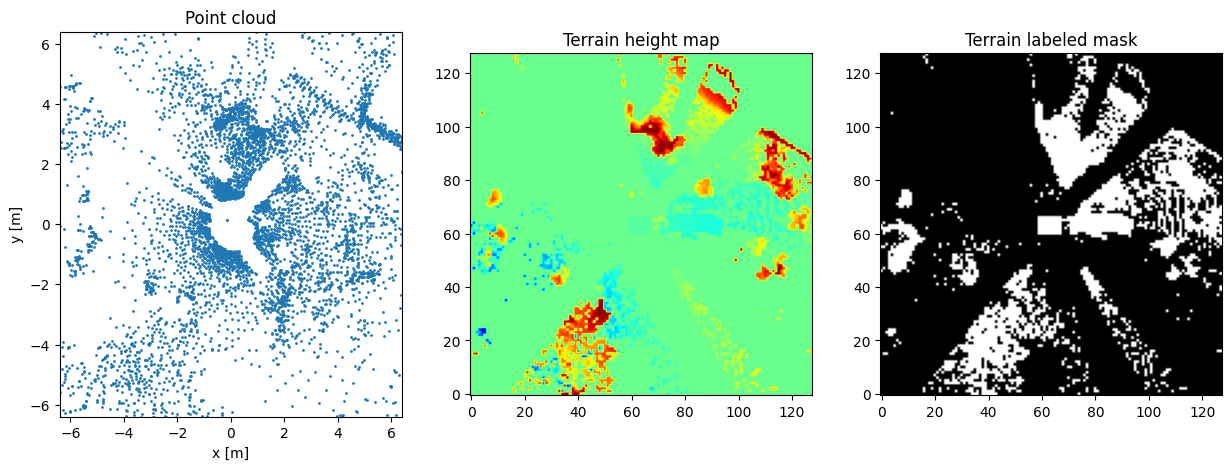

In [4]:
points, terrain = ds[0]

print(f'Points shape: {points.shape}')  # (3, N), N is the number of points
print(f'Terrain shape: {terrain.shape}')  # (2, H, W), stacked (height, labeled mask)

# visualize the point cloud and terrain height map
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
points_downsampled = points[:, ::10]
ax[0].scatter(points_downsampled[0], points_downsampled[1], s=1)
ax[0].set_title('Point cloud')
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
ax[0].set_xlim(-6.4, 6.4)
ax[0].set_ylim(-6.4, 6.4)

ax[1].imshow(terrain[0].T, cmap='jet', origin='lower')
ax[1].set_title('Terrain height map')

ax[2].imshow(terrain[1].T, cmap='gray', origin='lower')
ax[2].set_title('Terrain labeled mask')

plt.show()

## Model: LiDARBEV

The model is using a voxel grid representation of the point cloud as input.
This example contains only the point cloud part of the model.

Reference: https://hanlab.mit.edu/projects/bevfusion

In [5]:
model = LidarBEV(grid_conf=lss_config['grid_conf'], n_features=16, outC=1)
model.to(device)
print(f'Number of model parameters: {sum(p.numel() for p in model.parameters())}')

Number of model parameters: 4556546


In [6]:
loader = DataLoader(ds, batch_size=2, shuffle=True)

points, hm_terrain = next(iter(loader))
print(f'Points shape: {points.shape}')  # (B, 3, N), N is the number of points

Points shape: torch.Size([2, 3, 131072])


In [7]:
with torch.inference_mode():
    with torch.no_grad():
        out = model(points.to(device))
        terrain = out['terrain']
        print(f'Output shape: {terrain.shape}')  # (B, outC, H, W)

Output shape: torch.Size([2, 1, 128, 128])


## Training

In [8]:
from tqdm.auto import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

for epoch in range(10):
    epoch_loss = 0
    for i, batch in tqdm(enumerate(loader), total=len(loader)):
        batch = [b.to(device) for b in batch]
        points, hm_terrain = batch
        
        optimizer.zero_grad()
        
        out = model(points)
        terrain_pred = out['terrain']
        terrain, weights = hm_terrain[:, 0:1], hm_terrain[:, 1:2]
        loss = criterion(terrain_pred * weights, terrain * weights)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    epoch_loss /= len(loader)
    print(f'Epoch: {epoch}, Loss: {epoch_loss}')

  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.03994827163183973


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.02481857172790028


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.02074537297622079


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.017953849281184375


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.015665164322681016


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.015122045103150109


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.013304188351390795


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.012133778973726467


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.011117746812357967


  0%|          | 0/168 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.010372606022948665


## Inference

Visualizing an output of the model.

Predicted terrain shape: torch.Size([2, 1, 128, 128])


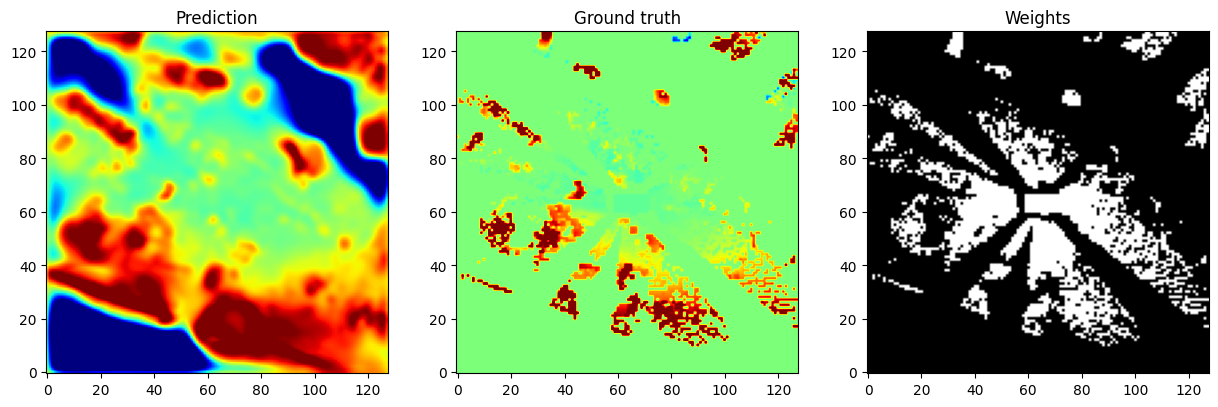

In [9]:
with torch.inference_mode():
    with torch.no_grad():
        batch = next(iter(loader))
        batch = [b.to(device) for b in batch]
        points, hm_terrain = batch
        terrain, weights = hm_terrain[:, 0:1], hm_terrain[:, 1:2]
        out = model(points)
        terrain_pred = out['terrain']
        print(f'Predicted terrain shape: {terrain_pred.shape}')  # (B, outC, H, W)
        
# visualize the output
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(terrain_pred[0, 0].cpu().numpy().T, cmap='jet', origin='lower', vmin=-1, vmax=1)
ax[0].set_title('Prediction')
ax[1].imshow(terrain[0, 0].cpu().numpy().T, cmap='jet', origin='lower', vmin=-1, vmax=1)
ax[1].set_title('Ground truth')
ax[2].imshow(weights[0, 0].cpu().numpy().T, cmap='gray', origin='lower')
ax[2].set_title('Weights')
plt.show()